## General Import

In [1]:
# !pip install geojson geopandas osmnx spektral matplotlib==3.1.3

# from google.colab import files
# from google.colab import drive

# drive.mount('/content/drive')

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler

import gc
import time
import seaborn as sns; sns.set()

import os 
# Disable warnings, set Matplotlib inline plotting and load Pandas package
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
#pd.options.display.mpl_style = 'default'
from datetime import datetime
import numpy as np
from datetime import datetime, timedelta
from pytz import timezone
from dateutil import tz
import geojson
import geopandas as gpd
from fiona.crs import from_epsg
import os, json
from shapely.geometry import shape, Point, Polygon, MultiPoint
%matplotlib inline
import matplotlib.pyplot as plt
from geopandas.tools import sjoin

import matplotlib.cm as cm

import folium
import shapely.geometry

from branca.colormap import  linear
import json
import branca.colormap as cm
import matplotlib.colors as colors
%matplotlib inline

import networkx as nx
import pickle

import osmnx as ox
ox.config(log_console=True, use_cache=True)
ox.__version__

import matplotlib.colors as mcolors
import gc

In [3]:
import tensorflow as tf
from tensorflow.keras import Model
from spektral.layers import GCNConv, ChebConv #(channels, K=1)
from spektral.utils import gcn_filter
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [4]:
from numpy.random import seed

# Reproducability
def set_seed(seed=31415):
    
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    
set_seed(31415)

In [5]:
path_graph = 'drive/MyDrive/Colab Notebooks/MTL traffic forecasting/direct graph/GRAPH_ADJ.pkl'

path_feat_flow = 'drive/MyDrive/Colab Notebooks/MTL traffic forecasting/direct graph/FEATURES_FLOW.csv'
path_feat_vel = 'drive/MyDrive/Colab Notebooks/MTL traffic forecasting/direct graph/FEATURES_VEL.csv'

with open(path_graph,'rb') as f:
    graph, adj_matrix, edges, G = pickle.load(f)

adj_mx = nx.to_numpy_matrix(graph)

# flow
features_flow = pd.read_csv(path_feat_flow).iloc[:,1:].values
# vel
features_vel = pd.read_csv(path_feat_vel).iloc[:,1:].values

In [6]:
# adj_matrix.shape

In [7]:
# features_flow.shape

In [8]:
# features_vel.shape

In [9]:
# PARAMETERS

In [10]:
inputs = 12

batch_train = 32 # best 32
batch_test = 1

## split train/val/test

In [11]:
data_flow = features_flow[:, :-1]
data_vel = features_vel[:, :-1]

data = np.concatenate([data_flow, data_vel], axis=1)

In [12]:
# data.shape

In [13]:
# Train/test split
data_tr, data_te = data[:-168*2*2, :], data[-168*2*2:, :]

In [14]:
# Covariates

In [15]:
datetime = features_flow[:, -1]

# for figures
print_datetime = datetime[-168*2*2+inputs:]

DATETIME = pd.DataFrame(datetime, columns=['Datetime'])
DATETIME['Datetime'] = pd.to_datetime(DATETIME['Datetime'])

DATETIME['minutes'] = DATETIME['Datetime'].dt.minute
DATETIME['hour'] = DATETIME['Datetime'].dt.hour

DATETIME['hour_x']=np.sin(DATETIME.hour*(2.*np.pi/23))
DATETIME['hour_y']=np.cos(DATETIME.hour*(2.*np.pi/23))

DATETIME['day'] = DATETIME['Datetime'].dt.day
DATETIME['DayOfWeek'] = DATETIME['Datetime'].dt.dayofweek

DATETIME['WorkingDays'] = DATETIME['DayOfWeek'].apply(lambda y: 2 if y < 5 else y)
DATETIME['WorkingDays'] = DATETIME['WorkingDays'].apply(lambda y: 1 if y == 5 else y)
DATETIME['WorkingDays'] = DATETIME['WorkingDays'].apply(lambda y: 0 if y == 6 else y)

DATETIME = DATETIME.drop(['Datetime','minutes','hour','day'], axis=1).values

# temporal features = 4
feat_time = 4

# datetime Train/test split
time_tr, time_te = DATETIME[:-168*2*2, :], DATETIME[-168*2*2:, :]



In [16]:
del data, data_flow, data_vel, features_flow, features_vel
gc.collect()

64

## scale data

In [17]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler_cov = MinMaxScaler(feature_range=(0, 1))

# fit and transform
scaled_tr = scaler.fit_transform(data_tr)
# transform
scaled_te = scaler.transform(data_te)

# fit and transform
scaled_tr_cov = scaler_cov.fit_transform(time_tr)
# transform
scaled_te_cov = scaler_cov.transform(time_te)

## prepare data for deep learning

In [18]:
def prepare_data_DL(INPUT, FEAT, BATCH):
    
    dataset = FEAT.reshape(FEAT.shape[0], FEAT.shape[1]) 
    dataset = tf.data.Dataset.from_tensor_slices(dataset)

    inputs = dataset.window(INPUT,  shift=1,  stride=1,  drop_remainder=True)
    inputs = inputs.flat_map(lambda window: window.batch(INPUT))

    targets = dataset.window(INPUT, shift=1,  stride=1,  drop_remainder=True).skip(INPUT)
    targets = targets.flat_map(lambda window: window.batch(INPUT))

    dataset = tf.data.Dataset.zip((inputs, targets))
    dataset = dataset.batch(BATCH).prefetch(tf.data.experimental.AUTOTUNE)


    return dataset

In [19]:
# features
loader_tr = prepare_data_DL(inputs, scaled_tr, batch_train)
loader_te = prepare_data_DL(inputs, scaled_te, batch_test)

# covariates
loader_tr_cov = prepare_data_DL(inputs, scaled_tr_cov, batch_train)
loader_te_cov = prepare_data_DL(inputs, scaled_te_cov, batch_test)

In [20]:
        # # encoder
        # self.e_tcn = tf.keras.layers.Conv1D(150, 2, padding ='same', activation ='relu')
        # self.pool = tf.keras.layers.MaxPool1D(pool_size=2, padding='same')

        # self.e_tcn_0 = tf.keras.layers.Conv1D(32, 2, padding ='same', activation ='relu')
        # self.pool_0 = tf.keras.layers.MaxPool1D(pool_size=2, padding='same')
 
        # # decoder
        # self.upsample_0 = tf.keras.layers.UpSampling1D(size=2)
        # self.d_tcn_0 = tf.keras.layers.Conv1D(32, 2, padding ='same', activation ='relu')

        # self.upsample = tf.keras.layers.UpSampling1D(size=2)
        # self.d_tcn = tf.keras.layers.Conv1D(150, 2, padding ='same', activation ='relu')


                # encoder
        # flow_vel = self.e_tcn(flow_vel)
        # flow_vel = self.pool(flow_vel)

        # flow_vel = self.e_tcn_0(flow_vel)
        # flow_vel = self.pool_0(flow_vel)
        
        # decoder
        # flow_vel = self.upsample_0(flow_vel)
        # flow_vel = self.d_tcn_0(flow_vel)

        # flow_vel = self.upsample(flow_vel)
        # flow_vel = self.d_tcn(flow_vel)

In [21]:
        # self.conv = tf.keras.layers.Conv1D(150, 2, padding ='same')

        # # block 1
        # self.conv_tanh = tf.keras.layers.Conv1D(150, 2, padding ='causal', activation = 'tanh')
        # self.conv_sigm = tf.keras.layers.Conv1D(150, 2, padding ='causal', activation = 'sigmoid') 

        # # temporal convolution
        # flow_vel = self.conv(flow_vel)

        # # block 1
        # tanh = self.conv_tanh(flow_vel)
        # sigm = self.conv_sigm(flow_vel)
        # gate = self.mult([tanh, sigm])
        # flow_vel = self.add([flow_vel, gate])

        # self.mult = tf.keras.layers.Multiply()


In [22]:
        # flow_vel = self.dense_temporal_0(flow_vel)
        # flow_vel = self.dense_temporal_1(flow_vel)
        # flow_vel = self.dense_temporal_2(flow_vel)

# self.dense_temporal_0 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(150))
#         self.dense_temporal_1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(50))
#         self.dense_temporal_2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(150))

In [23]:
l2_reg = 5e-4  # Regularization rate for l2

# Build model
class GCN_Net(Model):
    
    def __init__(self, **kwargs):
        
        super().__init__(**kwargs)



        self.dense_start = tf.keras.layers.Dense(5795)


        # GCN 1st order approximation
        self.gcn_flow_0_enc = GCNConv(12, activation="relu", kernel_regularizer=l2(l2_reg), use_bias=False)
        self.gcn_flow_1_enc = GCNConv(12, activation="relu", kernel_regularizer=l2(l2_reg), use_bias=False)

        self.gcn_vel_0_enc = GCNConv(12, activation="relu", kernel_regularizer=l2(l2_reg), use_bias=False)
        self.gcn_vel_1_enc = GCNConv(12, activation="relu", kernel_regularizer=l2(l2_reg), use_bias=False)



        # # cheb polinomial
        # self.cheb_flow = ChebConv(12,  2, activation="relu", kernel_regularizer=l2(l2_reg), use_bias=False)
        # self.cheb_vel = ChebConv(12, 2, activation="relu", kernel_regularizer=l2(l2_reg), use_bias=False)
        


###################

        # encoder GRU FLOW

        self.lstm_flow_init = tf.compat.v1.keras.layers.CuDNNGRU(150, #activation ='relu',
                                        kernel_initializer='glorot_uniform',
                                        recurrent_initializer='glorot_uniform',
                                        kernel_regularizer=regularizers.l2(0.001),
                                        bias_initializer='zeros', return_sequences = True, return_state =True)

        # decoder GRU FLOW
        self.lstm_flow_fin = tf.compat.v1.keras.layers.CuDNNGRU(150, #activation ='relu',
                                        kernel_initializer='glorot_uniform',
                                        recurrent_initializer='glorot_uniform',
                                        kernel_regularizer=regularizers.l2(0.001),
                                        bias_initializer='zeros')





        self.drop_flow = tf.keras.layers.Dropout(0.1)

        self.dense_flow_fin = tf.keras.layers.Dense(5975*12,
                                           kernel_regularizer=regularizers.l2(0.001))
        
        

##########################

        # encoder GRU VEL
        self.lstm_vel_init = tf.compat.v1.keras.layers.CuDNNGRU(150, #activation ='relu',
                                        kernel_initializer='glorot_uniform',
                                        recurrent_initializer='glorot_uniform',
                                        kernel_regularizer=regularizers.l2(0.001),
                                        bias_initializer='zeros', return_sequences = True, return_state =True)



        # decoder GRU VEL
        self.lstm_vel_fin = tf.compat.v1.keras.layers.CuDNNGRU(150, #activation ='relu',
                                        kernel_initializer='glorot_uniform',
                                        recurrent_initializer='glorot_uniform',
                                        kernel_regularizer=regularizers.l2(0.001),
                                        bias_initializer='zeros')



        self.drop_vel = tf.keras.layers.Dropout(0.1)


        self.dense_vel_fin = tf.keras.layers.Dense(5975*12,
                                           kernel_regularizer=regularizers.l2(0.001))
        
        
        # self.dense_vel_fin = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(5975,
        #                                    kernel_regularizer=regularizers.l2(0.001)))
        
        
##################################

        self.attention_flow = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=4)
        self.attention_vel = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=4)


        self.dense_temporal_0 = tf.keras.layers.Dense(150, activation ='relu') #tf.keras.layers.TimeDistributed()
        self.dense_temporal_1 = tf.keras.layers.Dense(64, activation ='relu')
        self.dense_temporal_2 = tf.keras.layers.Dense(150)


        self.drop = tf.keras.layers.Dropout(0.1)   

        self.add = tf.keras.layers.Add()
        self.norm = tf.keras.layers.LayerNormalization()

        self.reshape = tf.keras.layers.Reshape([12, 5975])
        self.repeat = tf.keras.layers.RepeatVector(12)
        

    def call(self, flow_vel, a, past_cov, fut_cov):

        # sparse matrix
        sparse_a = tf.sparse.from_dense(a)
        
        past_cov = tf.cast(past_cov, dtype=tf.float32)

        # lapl_a = gcn_filter(sparse_a, symmetric=True)
        # Cheb_a = chebyshev_filter(sparse_a, 2, symmetric=True)



        # flow
        flow_0 = flow_vel[:, :, :-5975]
        # velocity
        vel_0  = flow_vel[:, :, -5975:]
        

        # shape for gcn
        flow_sh = tf.reshape(flow_0 , [flow_0.shape[0], flow_0 .shape[2], flow_0.shape[1]])
        vel_sh = tf.reshape(vel_0 , [vel_0.shape[0], vel_0.shape[2], vel_0.shape[1]])

        # two gcn on flow and vel
        gcn_flow = self.gcn_flow_0_enc([flow_sh, sparse_a])
        gcn_flow = self.gcn_flow_1_enc([gcn_flow, sparse_a])


        # gcn_flow = self.cheb_flow([flow_sh, sparse_a])

        gcn_vel = self.gcn_vel_0_enc([vel_sh, sparse_a])
        gcn_vel = self.gcn_vel_1_enc([gcn_vel, sparse_a])

        # gcn_vel = self.cheb_vel([vel_sh, sparse_a])

        # shape for lstm
        flow_sh = tf.reshape(gcn_flow, [gcn_flow.shape[0], gcn_flow.shape[2], gcn_flow.shape[1]])
        vel_sh = tf.reshape(gcn_vel, [gcn_vel.shape[0], gcn_vel.shape[2], gcn_vel.shape[1]])


        
        # two lstm models
        flow_init, h_flow = self.lstm_flow_init(flow_sh)
        vel_init, h_vel = self.lstm_vel_init(vel_sh)


        # flow_init = self.repeat(h_flow)#
        # vel_init = self.repeat(h_vel)#



        # merge layer
        # output
        flow_vel_i = tf.concat([flow_init, vel_init], axis=2) # 

        flow_vel = self.dense_temporal_0(flow_vel_i)
        flow_vel = self.dense_temporal_1(flow_vel)
        flow_vel_f = self.dense_temporal_2(flow_vel)

        # flow_vel = self.repeat(flow_vel_f) #
        # add_flow_vel = self.add([flow_vel_i, flow_vel_f]) 


        # multi-head attention
        # # Q: flow & vel
        # # K: flow
        # att_flow = self.attention_flow(flow_init, add_flow_vel) #
        att_flow = self.attention_flow(flow_vel_f, flow_init)


        # # Q: vel & vel
        # # K: vel
        # att_vel = self.attention_vel(vel_init, add_flow_vel)
        att_vel = self.attention_vel(flow_vel_f, vel_init)

        # # add
        # add_flow = self.add([att_flow, flow_vel_f]) # flow_vel, flow_init
        # add_vel = self.add([att_vel, flow_vel_f]) # vel_init

# -----

        # concatenate covariates
        # output flow_vel - covariates
        fut_cov = tf.cast(fut_cov, dtype=tf.float32)
        concat_flow = tf.concat([att_flow, fut_cov], axis=2)
        concat_vel = tf.concat([att_vel, fut_cov], axis=2)
  
        # two models for flow and speed respectively

        # flow
        flow_final = self.lstm_flow_fin(concat_flow) # , initial_state = [flow_vel_f]) #  flow_vel_f, h_flow flow_vel_f[:,-1,:]
        flow = self.drop_flow(flow_final)
        flow = self.dense_flow_fin(flow)
        flow = self.reshape(flow)


        # velocity
        vel_final = self.lstm_vel_fin(concat_vel) # , initial_state = [flow_vel_f]) 
        vel = self.drop_vel(vel_final)
        vel = self.dense_vel_fin(vel)
        vel = self.reshape(vel)


        # concatenate two finals results
        final = tf.concat([flow, vel], axis=-1)

        return final


# Create model
model = GCN_Net()
optimizer = Adam(lr=0.001)
loss_fn = tf.keras.losses.MeanAbsoluteError()

In [24]:
adj_matrix = gcn_filter(adj_matrix, symmetric=True)

In [25]:
# Training function
@tf.function
def train_on_batch(inputs, target, past_cov, fut_cov):
    
    loss = 0

    with tf.GradientTape() as tape:
        
        predictions = model(inputs, adj_matrix, past_cov, fut_cov, training=True)
        
        loss = loss_fn(target, predictions)

    variables = model.trainable_variables 

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))
    
    return loss

In [26]:
EPOCHS = 125

# Keep results for plotting
train_loss_results = []

samples_cov = list(loader_tr_cov)

for epoch in range(EPOCHS):
    
    start = time.time()

    epoch_loss_avg = tf.keras.metrics.Mean()
     
    step = 0

    for batch in loader_tr:

        cov = samples_cov[step]
        past_cov = cov[0]
        fut_cov = cov[1]
        
        # Training step
        inputs, target = batch
        
        loss = train_on_batch(inputs, target, past_cov, fut_cov)
        
        # Track progress
        epoch_loss_avg.update_state(loss)

        step+=1

    # End epoch
    train_loss_results.append(epoch_loss_avg.result())

    if epoch % 10 == 0:
            print("Epoch {}: Loss MAE: {:.4f}".format(epoch, epoch_loss_avg.result()))
        
print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 0: Loss MAE: 0.1591
Epoch 10: Loss MAE: 0.0815
Epoch 20: Loss MAE: 0.0779
Epoch 30: Loss MAE: 0.0749
Epoch 40: Loss MAE: 0.0740
Epoch 50: Loss MAE: 0.0717
Epoch 60: Loss MAE: 0.0714
Epoch 70: Loss MAE: 0.0703
Epoch 80: Loss MAE: 0.0699
Epoch 90: Loss MAE: 0.0694
Epoch 100: Loss MAE: 0.0691
Epoch 110: Loss MAE: 0.0689
Epoch 120: Loss MAE: 0.0689
Time taken for 1 epoch 5.402155160903931 sec



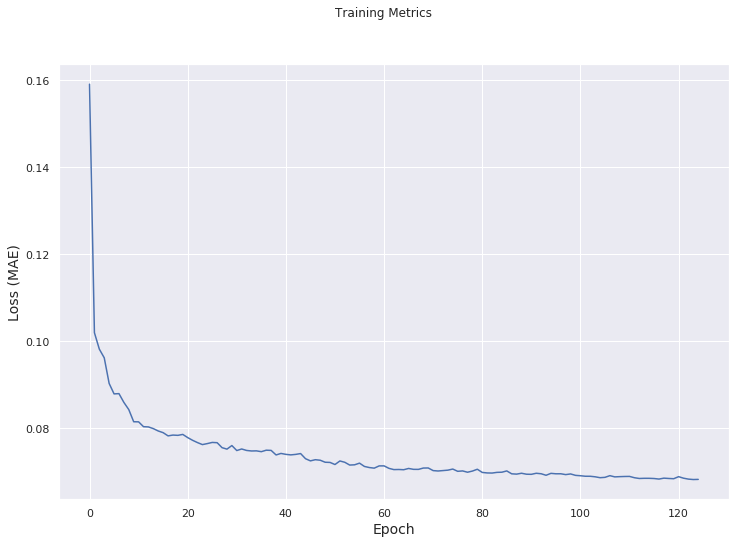

In [27]:
fig, axes = plt.subplots(1, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes.set_ylabel("Loss (MAE)", fontsize=14)
axes.plot(train_loss_results)
axes.set_xlabel("Epoch", fontsize=14)
plt.show()

In [28]:
def inverse_transform(forecasts, scaler):
    # invert scaling
    inv_pred = scaler.inverse_transform(forecasts)
    return inv_pred

In [29]:
def evaluate_forecasts(targets, forecasts, n_seq):
    
    list_rmse = []
    list_mae = []
    
    for i in range(n_seq):
        true = np.vstack([target[i] for target in targets])
        predicted = np.vstack([forecast[i] for forecast in forecasts])
        
        rmse = np.sqrt((np.square(true - predicted)).mean(axis=0))
        mae = np.absolute(true - predicted).mean(axis=0)
        
        list_rmse.append(rmse)
        list_mae.append(mae)
        
    list_rmse = np.vstack(list_rmse)
    list_mae = np.vstack(list_mae)
    
    return list_rmse, list_mae

In [30]:
forecasts = []
targets = []

rmse_list = []
mae_list = []

samples_cov = list(loader_te_cov)

    
for (step, (inp, targ)) in enumerate(loader_te):
    
            
        timestamp = print_datetime[step]
        print(timestamp)

        cov = samples_cov[step]
        past_cov = cov[0]
        fut_cov = cov[1]
        
        pred  = model(inp, adj_matrix, past_cov, fut_cov, training=False)
        print(pred.shape)
        
        truth = inverse_transform(targ[0],  scaler)
        pred = inverse_transform(pred[0],  scaler)
        
        forecasts.append(pred)
        targets.append(truth)

        rmse, mae = evaluate_forecasts(targets, forecasts, 12)
           
        rmse_list.append(rmse)
        mae_list.append(mae)

         
        # fig = plt.figure(figsize=(10, 5))   
        # plt.plot(np.sum(pred[:, :5975], axis=1), label='Prediction') 
        # plt.plot(np.sum(truth[:, :5975], axis=1), label='Truth') 
        # plt.title('Sum flow Prediction on all highways in Belgium')
        # plt.legend()
        # plt.show()
        # fig.clear()
        # plt.close(fig)       
        # plt.show()

        # fig = plt.figure(figsize=(10, 5))   
        # plt.plot(np.mean(pred[:, 5975:], axis=1), label='Prediction') 
        # plt.plot(np.mean(truth[:, 5975:], axis=1), label='Truth') 
        # plt.title('Sum Velocity Prediction on all highways in Belgium')
        # plt.legend()
        # plt.show()
        # fig.clear()
        # plt.close(fig)       
        # plt.show()

        print('* Time step '+str(step))
        print('* Prediction Accuracy (MAE) '+ str(np.absolute(truth - pred).mean()))
        print('----')
        
        
        new_instance = scaled_te[step,:].reshape(1,-1)
        new_instance_cov = scaled_te_cov[step,:].reshape(1,-1)
    
        scaled_tr = np.vstack([scaled_tr[1:], new_instance])
        scaled_tr_cov = np.vstack([scaled_tr_cov[1:], new_instance_cov])
        
        loader_new = prepare_data_DL(12, scaled_tr, batch_train)
        loader_new_cov = prepare_data_DL(12, scaled_tr_cov, batch_train)
        
        UPDATE = 2
        time_update = 168*2

        if step % time_update == 0:

          print('')
          print('* Time to UPDATE the Model after '+str(time_update)+' steps')
          print('')
          sample_cov_new = list(loader_new_cov) 
          

          for epoch in range(UPDATE):

            step_new = 0
            
            for batch in loader_new:

              cov_new = sample_cov_new[step_new]

              past_cov_new = cov_new[0]
              future_cov_new = cov_new[1]
              
              inp_new, targ_new = batch

              loss = train_on_batch(inp_new, targ_new, past_cov_new, future_cov_new)

              # Track progress
              epoch_loss_avg.update_state(loss)

              # End epoch
              train_loss_results.append(epoch_loss_avg.result())

              step_new+=1

            

    

2019-02-15 06:00:00
(1, 12, 11950)
* Time step 0
* Prediction Accuracy (MAE) 7.270316758061411
----

* Time to UPDATE the Model after 336 steps

2019-02-15 06:30:00
(1, 12, 11950)
* Time step 1
* Prediction Accuracy (MAE) 7.137534254044134
----
2019-02-15 07:00:00
(1, 12, 11950)
* Time step 2
* Prediction Accuracy (MAE) 7.070768900401249
----
2019-02-15 07:30:00
(1, 12, 11950)
* Time step 3
* Prediction Accuracy (MAE) 6.987804127127681
----
2019-02-15 08:00:00
(1, 12, 11950)
* Time step 4
* Prediction Accuracy (MAE) 6.996578148893246
----
2019-02-15 08:30:00
(1, 12, 11950)
* Time step 5
* Prediction Accuracy (MAE) 6.939324700426783
----
2019-02-15 09:00:00
(1, 12, 11950)
* Time step 6
* Prediction Accuracy (MAE) 7.115715132887152
----
2019-02-15 09:30:00
(1, 12, 11950)
* Time step 7
* Prediction Accuracy (MAE) 9.810026953756402
----
2019-02-15 10:00:00
(1, 12, 11950)
* Time step 8
* Prediction Accuracy (MAE) 9.640446799583888
----
2019-02-15 10:30:00
(1, 12, 11950)
* Time step 9
* Pred

In [31]:
np.mean(rmse_list)

11.063821669127654

In [32]:
np.mean(mae_list)

6.24655453338082

In [33]:
RMSE_MEAN = np.mean(rmse_list,axis=0).mean(axis=1)
RMSE_STD =  np.std(rmse_list,axis=0).std(axis=1)

for i in range(len(RMSE_MEAN)):
    print('t+'+str(i+1)+' RMSE MEAN ' +str(np.round(RMSE_MEAN[i],3))+' +- '+str(np.round(RMSE_STD[i],3)))
    print('')

t+1 RMSE MEAN 11.081 +- 2.246

t+2 RMSE MEAN 11.242 +- 2.439

t+3 RMSE MEAN 11.229 +- 2.407

t+4 RMSE MEAN 11.239 +- 2.435

t+5 RMSE MEAN 11.226 +- 2.47

t+6 RMSE MEAN 11.245 +- 2.626

t+7 RMSE MEAN 11.296 +- 2.987

t+8 RMSE MEAN 10.923 +- 2.209

t+9 RMSE MEAN 10.786 +- 1.993

t+10 RMSE MEAN 10.799 +- 1.969

t+11 RMSE MEAN 10.833 +- 1.947

t+12 RMSE MEAN 10.865 +- 1.927



In [34]:
MAE_MEAN = np.mean(mae_list,axis=0).mean(axis=1)
MAE_STD =  np.std(mae_list,axis=0).std(axis=1)

for i in range(len(MAE_MEAN)):
    print('t+'+str(i+1)+' MAE MEAN ' +str(np.round(MAE_MEAN[i],3))+' +- '+str(np.round(MAE_STD[i],3)))
    print('')

t+1 MAE MEAN 6.237 +- 1.384

t+2 MAE MEAN 6.324 +- 1.634

t+3 MAE MEAN 6.318 +- 1.613

t+4 MAE MEAN 6.312 +- 1.617

t+5 MAE MEAN 6.299 +- 1.653

t+6 MAE MEAN 6.298 +- 1.83

t+7 MAE MEAN 6.331 +- 2.432

t+8 MAE MEAN 6.182 +- 1.588

t+9 MAE MEAN 6.123 +- 1.297

t+10 MAE MEAN 6.145 +- 1.276

t+11 MAE MEAN 6.176 +- 1.253

t+12 MAE MEAN 6.213 +- 1.23



In [35]:
with open('noAdd_RMSE.pkl', 'wb') as f:  
    pickle.dump(rmse_list, f)

!cp noAdd_RMSE.pkl "drive/MyDrive/Colab Notebooks/MTL traffic forecasting/Results/"
print('RMSE')


with open('noAdd_MAE.pkl', 'wb') as f:  
    pickle.dump(mae_list, f)

!cp noAdd_MAE.pkl "drive/MyDrive/Colab Notebooks/MTL traffic forecasting/Results/"
print('MAE')

RMSE
MAE


In [36]:
while True:pass

KeyboardInterrupt: ignored